In [202]:
import os
import sys
import numpy as np
import pandas as pd
from datetime import datetime
from scipy.ndimage import gaussian_filter1d

import glob
import hyss_util as hu
from sklearn.model_selection import train_test_split
from plotting import set_defaults
from pandas.plotting import scatter_matrix
from scipy import stats
import random
import matplotlib.pyplot as plt
import matplotlib.patches as patches
%matplotlib inline

In [203]:
# -- get some ancillary data
sc     = pd.read_csv("../../../gdobler_output/output/scan_conditions.csv")

In [204]:
sc[0:10]

,Unnamed: 0,time,filename,temperature,dew_point,pressure,humidity,hourly_precipitation,pm25,o3
0,0,2016 May 2 17:46,veg_00000.raw,61.5,53.9,29.71,76.0,-99.99,8.078333,0.01175
1,1,2016 May 2 18:01,veg_00001.raw,62.4,54.4,29.71,75.0,-99.99,8.078333,0.01175
2,2,2016 May 3 08:01,veg_00002.raw,53.2,52.9,29.67,99.0,-99.99,2.160833,0.01425
3,3,2016 May 3 08:16,veg_00003.raw,53.4,53.1,29.66,99.0,-99.99,2.160833,0.01425
4,4,2016 May 3 08:31,veg_00004.raw,53.8,53.5,29.66,99.0,-99.99,3.147500,0.01425
5,5,2016 May 3 08:46,veg_00005.raw,53.8,53.5,29.66,99.0,-99.99,3.147500,0.01425
6,6,2016 May 3 09:01,veg_00006.raw,54.0,53.7,29.65,99.0,-99.99,3.147500,0.01425
7,7,2016 May 3 09:16,veg_00007.raw,53.8,53.5,29.65,99.0,-99.99,3.147500,0.01425
8,8,2016 May 3 09:31,veg_00008.raw,53.6,53.3,29.66,99.0,-99.99,2.144167,0.01775
9,9,2016 May 3 09:46,veg_00009.raw,53.4,53.1,29.65,99.0,-99.99,2.144167,0.01775


In [205]:
DateTime = []
Date  = []
Time  = []
for stime in sc.time.values:
    yr, mo, dy, tm = stime.split()
    stime_fmt = "{0} {1} {2:02} {3}:00".format(yr,mo,int(dy),tm)
    obs_dt = datetime.strptime(stime_fmt,"%Y %b %d %H:%M:%S")
    DateTime.append(obs_dt)
    Date.append(datetime.date(obs_dt))
    Time.append(datetime.time(obs_dt))

sc['DateTime'] = DateTime
sc['Date'] = Date
sc['Time'] = Time
#sc = sc.set_index('DateTime')

In [206]:
sc.head()

,Unnamed: 0,time,filename,temperature,dew_point,pressure,humidity,hourly_precipitation,pm25,o3,DateTime,Date,Time
0,0,2016 May 2 17:46,veg_00000.raw,61.5,53.9,29.71,76.0,-99.99,8.078333,0.01175,2016-05-02 17:46:00,2016-05-02,17:46:00
1,1,2016 May 2 18:01,veg_00001.raw,62.4,54.4,29.71,75.0,-99.99,8.078333,0.01175,2016-05-02 18:01:00,2016-05-02,18:01:00
2,2,2016 May 3 08:01,veg_00002.raw,53.2,52.9,29.67,99.0,-99.99,2.160833,0.01425,2016-05-03 08:01:00,2016-05-03,08:01:00
3,3,2016 May 3 08:16,veg_00003.raw,53.4,53.1,29.66,99.0,-99.99,2.160833,0.01425,2016-05-03 08:16:00,2016-05-03,08:16:00
4,4,2016 May 3 08:31,veg_00004.raw,53.8,53.5,29.66,99.0,-99.99,3.147500,0.01425,2016-05-03 08:31:00,2016-05-03,08:31:00


In [207]:
sc.groupby('Date')['Date'].count()

Date
2016-05-02     2
2016-05-03    41
2016-05-04    41
2016-05-05    41
2016-05-06    41
2016-05-07    41
2016-05-08    41
2016-05-09    41
2016-05-10    41
2016-05-11    41
2016-05-12    41
2016-05-13    41
2016-05-14    41
2016-05-15    41
2016-05-16    41
2016-05-17    41
2016-05-18    41
2016-05-19    41
2016-05-20    40
2016-05-21    41
2016-05-22    41
2016-05-23    41
2016-05-24    41
2016-05-25    41
2016-05-31    29
2016-06-01    41
2016-06-02    41
2016-06-03    41
2016-06-04    41
2016-06-05    41
2016-06-06    41
2016-06-07    41
2016-06-08    40
Name: Date, dtype: int64

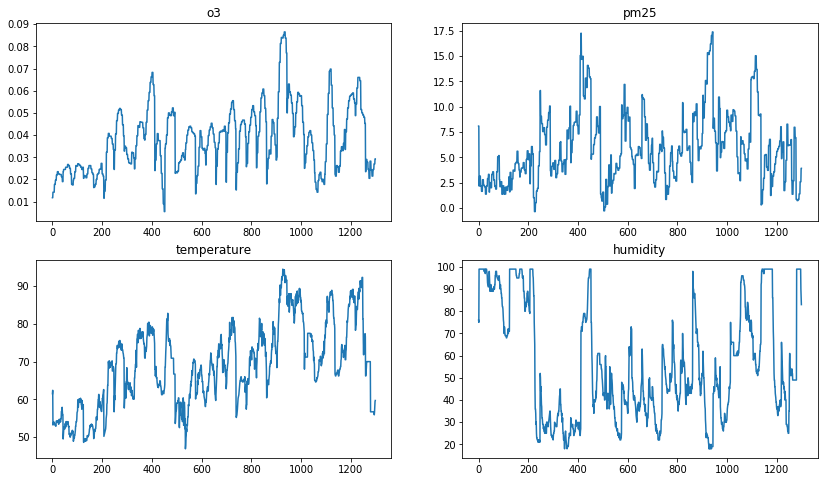

In [208]:
fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2, figsize=(14,8))
ax1.plot(sc['o3'])
ax1.set_title('o3')
ax2.plot(sc['pm25'])
ax2.set_title('pm25')
ax3.plot(sc['temperature'])
ax3.set_title('temperature')
ax4.plot(sc['humidity'])
ax4.set_title('humidity')
plt.show()

In [215]:
gO3 = np.array([])
gPM25 = np.array([])
gTemps = np.array([])
gHumid = np.array([])
for d in range(len(list(sc.groupby('Date')))):
    oz = list(sc.groupby('Date')['o3'])[d][1]
    gaussO = gaussian_filter1d(oz, 5)
    gO3 = np.append(gO3,gaussO)
    
    pm = list(sc.groupby('Date')['pm25'])[d][1]
    gaussP = gaussian_filter1d(pm, 5)
    gPM25 = np.append(gPM25,gaussP)
    
    temps = list(sc.groupby('Date')['temperature'])[d][1]
    gaussT = gaussian_filter1d(temps, 5)
    gTemps = np.append(gTemps,gaussT) 
    
    hums = list(sc.groupby('Date')['humidity'])[d][1]
    gaussH = gaussian_filter1d(hums, 5)
    gHumid = np.append(gHumid,gaussH)

In [216]:
sc['gO3'] = gO3
sc['gPM25'] = gPM25
sc['gTemps'] = gTemps
sc['gHumid'] = gHumid

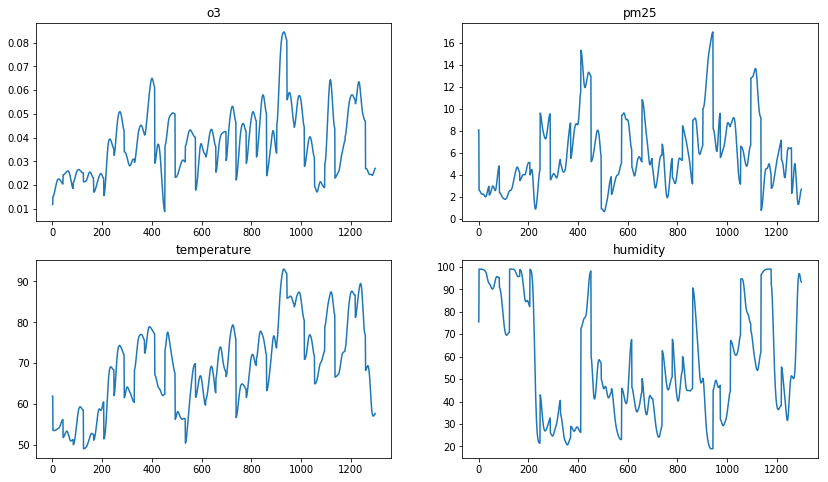

In [218]:
fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2, figsize=(14,8))
#ax1.plot(sc['o3'])
ax1.plot(sc['gO3'])
ax1.set_title('o3')
#ax2.plot(sc['pm25'])
ax2.plot(sc['gPM25'])
ax2.set_title('pm25')
#ax3.plot(sc['temperature'])
ax3.plot(sc['gTemps'])
ax3.set_title('temperature')
#ax4.plot(sc['humidity'])
ax4.plot(sc['gHumid'])
ax4.set_title('humidity')
plt.show()

In [23]:
# -- define good scans
good = np.array([int(i) for i in np.load("../../../gdobler_output/output/good_scans.npy")])
sc_sub = sc[sc.filename.isin(["veg_{0:05}.raw".format(i) for i in good])]

#### Get air quality data

In [10]:
# -- get some ancillary data
sc     = pd.read_csv("../../../gdobler_output/output/scan_conditions.csv")
sc_sub = sc[sc.filename.isin(["veg_{0:05}.raw".format(i) for i in good])]

temps = sc_sub.temperature.values
humid = sc_sub.humidity.values
pm25  = sc_sub.pm25.values
o3    = sc_sub.o3.values
secs  = []
for stime in sc_sub.time.values:
    yr, mo, dy, tm = stime.split()
    stime_fmt      = "{0} {1} {2:02} {3}:00".format(yr,mo,int(dy),tm)
    obs_dt         = datetime.strptime(stime_fmt,"%Y %b %d %H:%M:%S")
    secs.append(float(obs_dt.strftime("%s")))
secs = np.array(secs)

In [11]:
opth = pd.DataFrame({'$O_3$': o3, '$PM_{2.5}$': pm25, 'Temperature': temps, 'Humidity':humid})
opth.describe()

,$O_3$,$PM_{2.5}$,Humidity,Temperature
count,1102.000000,1102.000000,1102.000000,1102.000000
mean,0.038318,6.198070,54.506352,68.924592
std,0.014651,3.558875,25.721231,10.497654
min,0.005500,-0.362000,18.000000,46.900000
25%,0.026250,3.569470,33.000000,61.900000
50%,0.038500,5.581250,47.000000,69.100000
75%,0.046500,8.316667,75.000000,76.100000
max,0.086500,17.365833,99.000000,94.500000


Text(0.5,0.95,'Air Quality Scatter Matrix')

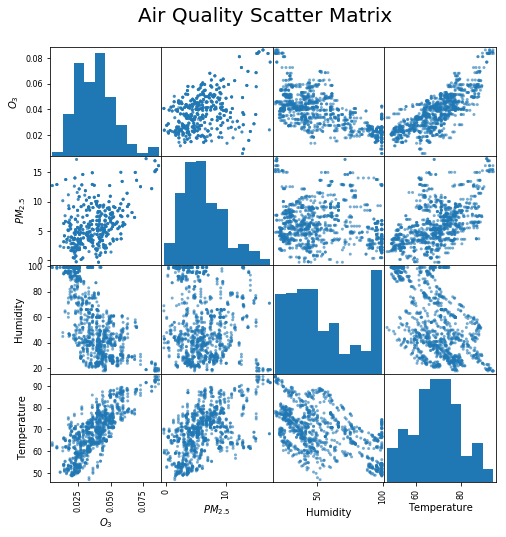

In [12]:
plt.rcParams['font.size'] = 10
#fig, ax = plt.subplots(figsize=[10,10])
mtx = scatter_matrix(opth, alpha=0.6, figsize=(8,8), diagonal='hist')
plt.suptitle("Air Quality Scatter Matrix", y=0.95, fontsize=20)
#plt.savefig("../farid_output/air_quality_scatter_matrix.pdf", dpi=300)
#plt.savefig("../farid_output/air_quality_scatter_matrix.png", dpi=300)

In [51]:
# bin air quality into discrete bins for classification
o3_bins = 20
opth['o3_int'] = pd.cut(opth['$O_3$'], bins=o3_bins)
opth['o3_mid'] = [round(s.mid,4) for s in opth['o3_int']]
opth['o3_label'] = pd.cut(opth['$O_3$'], bins=o3_bins, labels=np.arange(o3_bins))

pm25_bins = 20
opth['pm25_int'] = pd.cut(opth['$PM_{2.5}$'], bins=pm25_bins)
opth['pm25_mid'] = [round(s.mid,4) for s in opth['pm25_int']]
opth['pm25_label'] = pd.cut(opth['$PM_{2.5}$'], bins=pm25_bins, labels=np.arange(pm25_bins))

temp_bins = 20
opth['temp_int'] = pd.cut(opth['Temperature'], bins=temp_bins)
opth['temp_mid'] = [round(s.mid,4) for s in opth['temp_int']]
opth['temp_label'] = pd.cut(opth['Temperature'], bins=temp_bins, labels=np.arange(temp_bins))

humid_bins = 20
opth['humid_int'] = pd.cut(opth['Humidity'], bins=humid_bins)
opth['humid_mid'] = [round(s.mid,4) for s in opth['humid_int']]
opth['humid_label'] = pd.cut(opth['Humidity'], bins=humid_bins, labels=np.arange(humid_bins))

In [52]:
opth['o3_int'].value_counts()

(0.0379, 0.0419]      150
(0.0217, 0.0257]      129
(0.0419, 0.046]       114
(0.0257, 0.0298]      108
(0.0338, 0.0379]       95
(0.0298, 0.0338]       95
(0.046, 0.05]          88
(0.0176, 0.0217]       75
(0.05, 0.0541]         62
(0.0541, 0.0581]       47
(0.0136, 0.0176]       33
(0.0581, 0.0622]       32
(0.0824, 0.0865]       20
(0.0622, 0.0662]       20
(0.0662, 0.0703]       12
(0.00542, 0.00955]      7
(0.0784, 0.0824]        4
(0.0703, 0.0744]        4
(0.00955, 0.0136]       4
(0.0744, 0.0784]        3
Name: o3_int, dtype: int64

In [53]:
opth['pm25_int'].value_counts()

(4.956, 5.843]      127
(3.184, 4.07]       124
(4.07, 4.956]       114
(5.843, 6.729]      113
(1.411, 2.297]       83
(2.297, 3.184]       83
(8.502, 9.388]       83
(6.729, 7.616]       79
(7.616, 8.502]       65
(9.388, 10.275]      47
(12.047, 12.934]     29
(10.275, 11.161]     28
(-0.38, 0.524]       26
(0.524, 1.411]       25
(14.707, 15.593]     23
(12.934, 13.82]      20
(11.161, 12.047]     12
(16.479, 17.366]      9
(13.82, 14.707]       8
(15.593, 16.479]      4
Name: pm25_int, dtype: int64

In [54]:
opth['temp_int'].value_counts()

(68.32, 70.7]      105
(70.7, 73.08]      103
(63.56, 65.94]      98
(73.08, 75.46]      90
(75.46, 77.84]      88
(65.94, 68.32]      87
(61.18, 63.56]      76
(51.66, 54.04]      65
(77.84, 80.22]      57
(49.28, 51.66]      51
(58.8, 61.18]       51
(84.98, 87.36]      45
(56.42, 58.8]       37
(54.04, 56.42]      35
(87.36, 89.74]      29
(80.22, 82.6]       27
(82.6, 84.98]       22
(92.12, 94.5]       14
(46.852, 49.28]     12
(89.74, 92.12]      10
Name: temp_int, dtype: int64

In [55]:
opth['humid_int'].value_counts()

(94.95, 99.0]      162
(26.1, 30.15]       94
(22.05, 26.1]       91
(42.3, 46.35]       90
(38.25, 42.3]       85
(34.2, 38.25]       71
(46.35, 50.4]       66
(30.15, 34.2]       56
(17.919, 22.05]     56
(58.5, 62.55]       53
(54.45, 58.5]       41
(62.55, 66.6]       40
(74.7, 78.75]       40
(50.4, 54.45]       37
(90.9, 94.95]       30
(86.85, 90.9]       30
(70.65, 74.7]       23
(66.6, 70.65]       13
(78.75, 82.8]       13
(82.8, 86.85]       11
Name: humid_int, dtype: int64

In [56]:
opth

,$O_3$,$PM_{2.5}$,Humidity,Temperature,o3_int,o3_label,pm25_int,pm25_label,temp_int,temp_label,humid_int,humid_label,o3_mid,pm25_mid,temp_mid,humid_mid
0,0.014250,2.160833,99.0,53.2,"(0.0136, 0.0176]",2,"(1.411, 2.297]",2,"(51.66, 54.04]",2,"(94.95, 99.0]",19,0.0156,1.8540,52.85,96.975
1,0.014250,2.160833,99.0,53.4,"(0.0136, 0.0176]",2,"(1.411, 2.297]",2,"(51.66, 54.04]",2,"(94.95, 99.0]",19,0.0156,1.8540,52.85,96.975
2,0.014250,3.147500,99.0,53.8,"(0.0136, 0.0176]",2,"(2.297, 3.184]",3,"(51.66, 54.04]",2,"(94.95, 99.0]",19,0.0156,2.7405,52.85,96.975
3,0.014250,3.147500,99.0,53.8,"(0.0136, 0.0176]",2,"(2.297, 3.184]",3,"(51.66, 54.04]",2,"(94.95, 99.0]",19,0.0156,2.7405,52.85,96.975
4,0.014250,3.147500,99.0,54.0,"(0.0136, 0.0176]",2,"(2.297, 3.184]",3,"(51.66, 54.04]",2,"(94.95, 99.0]",19,0.0156,2.7405,52.85,96.975
5,0.014250,3.147500,99.0,53.8,"(0.0136, 0.0176]",2,"(2.297, 3.184]",3,"(51.66, 54.04]",2,"(94.95, 99.0]",19,0.0156,2.7405,52.85,96.975
6,0.017750,2.144167,99.0,53.6,"(0.0176, 0.0217]",3,"(1.411, 2.297]",2,"(51.66, 54.04]",2,"(94.95, 99.0]",19,0.0196,1.8540,52.85,96.975
7,0.017750,2.144167,99.0,53.4,"(0.0176, 0.0217]",3,"(1.411, 2.297]",2,"(51.66, 54.04]",2,"(94.95, 99.0]",19,0.0196,1.8540,52.85,96.975
8,0.017750,2.144167,99.0,53.2,"(0.0176, 0.0217]",3,"(1.411, 2.297]",2,"(51.66, 54.04]",2,"(94.95, 99.0]",19,0.0196,1.8540,52.85,96.975
9,0.017750,2.144167,99.0,53.1,"(0.0176, 0.0217]",3,"(1.411, 2.297]",2,"(51.66, 54.04]",2,"(94.95, 99.0]",19,0.0196,1.8540,52.85,96.975


In [57]:
#normalize air quality arrays

#o3 = stats.zscore(o3)
#pm25 = stats.zscore(pm25)
#temps = stats.zscore(temps)
#humid = stats.zscore(humid)

In [58]:
# create air quality array

#aq_opth = np.vstack((o3, pm25, temps, humid)).T
#print(aq_opth.shape)

### Split data into train/test sets

In [59]:
o3labels = np.array(opth['o3_label'].values)
pm25labels = np.array(opth['pm25_label'].values)
templabels = np.array(opth['temp_label'].values)
humidlabels = np.array(opth['humid_label'].values)

In [60]:
Dtrain, Dtest, \
o3train, o3test, \
pm25train, pm25test, \
temptrain, temptest, \
humidtrain, humidtest = train_test_split(D_vrat, o3labels, pm25labels,
                                         templabels, humidlabels, test_size=0.2, random_state=314)